# Import the dataset

In [1]:
# First, we need to import our libraries

import gc
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Now, let's set up our constant variables

PATH = 'cian-sales-2018-2021.csv'

REGION_ID = 3  # City of Moscow. Let's focus on the main RE market in country

MIN_AREA = 20  # Outlier range for floor area
MAX_AREA = 200

MIN_KITCHEN = 6  # Outlier range for kitchen area
MAX_KITCHEN = 30

MIN_PRICE = 1_500_000  # Outlier range for price
MAX_PRICE = 50_000_000

SEED = 15
N_FOLDS = 5

In [3]:
# Now, let's read our initial dataset

df = pd.read_csv(PATH)
print(f'Data shape: {df.shape}')
df.head()

Data shape: (5477006, 13)


,price,date,time,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type
0,6050000,2018-02-19,20:00:21,59.805808,30.376141,2661,1,8,10,3,82.6,10.8,1
1,8650000,2018-02-27,12:04:54,55.683807,37.297405,81,3,5,24,2,69.1,12.0,1
2,4000000,2018-02-28,15:44:00,56.295250,44.061637,2871,1,5,9,3,66.0,10.0,1
3,1850000,2018-03-01,11:24:52,44.996132,39.074783,2843,4,12,16,2,38.0,5.0,11
4,5450000,2018-03-01,17:42:43,55.918767,37.984642,81,3,13,14,2,60.0,10.0,1


In [4]:
# What is the columns dtypes?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5477006 entries, 0 to 5477005
Data columns (total 13 columns):
 #   Column         Dtype  
---  ------         -----  
 0   price          int64  
 1   date           object 
 2   time           object 
 3   geo_lat        float64
 4   geo_lon        float64
 5   region         int64  
 6   building_type  int64  
 7   level          int64  
 8   levels         int64  
 9   rooms          int64  
 10  area           float64
 11  kitchen_area   float64
 12  object_type    int64  
dtypes: float64(4), int64(7), object(2)
memory usage: 543.2+ MB


In [5]:
# As we know from our EDA, this dataset has no Null values, but has some duplicates
df.duplicated().sum()

1523

In [5]:
# let's drop the duplicates we found
df = df.drop_duplicates()

In [7]:
# basic data exploration in proper format
df.describe().apply(lambda s: s.apply('{0:.5f}'.format)) 

,price,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type
count,5475483.00000,5475483.00000,5475483.00000,5475483.00000,5475483.00000,5475483.00000,5475483.00000,5475483.00000,5475483.00000,5475483.00000,5475483.00000
mean,4421478.23207,54.03784,53.24654,4307.44040,1.94903,6.21382,11.39749,1.72621,53.91823,10.62817,3.94383
std,21510157.54730,4.62298,20.74788,3307.99089,1.03857,4.95679,6.53497,1.08214,33.35522,9.79337,4.55765
min,-2144967296.00000,41.45906,19.89020,3.00000,0.00000,1.00000,1.00000,-2.00000,0.07000,0.01000,1.00000
25%,1950000.00000,53.37726,37.77797,2661.00000,1.00000,2.00000,5.00000,1.00000,38.00000,7.00000,1.00000
50%,2990000.00000,55.17128,43.07021,2922.00000,2.00000,5.00000,10.00000,2.00000,48.02000,9.70000,1.00000
75%,4800020.00000,56.22613,65.64969,6171.00000,3.00000,9.00000,16.00000,2.00000,63.13000,12.70000,11.00000
max,2147483647.00000,71.98040,162.53608,61888.00000,5.00000,39.00000,39.00000,10.00000,7856.00000,9999.00000,11.00000


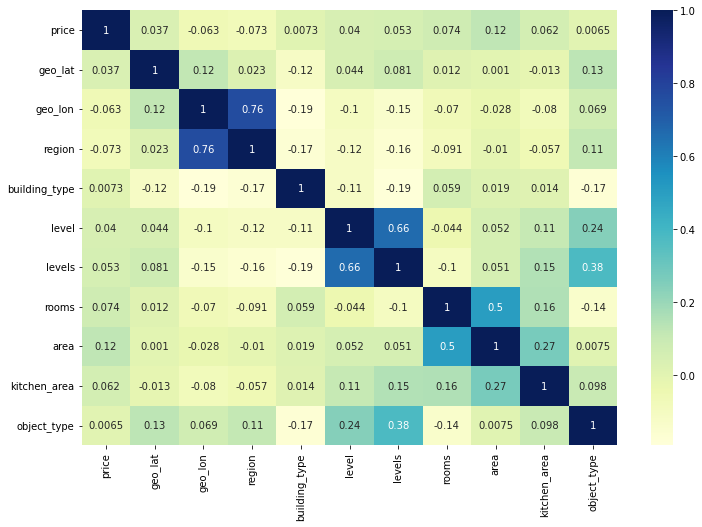

In [34]:
# checking the features correlation matrix

ax = sns.heatmap(df.corr(), cmap="YlGnBu", annot = True )
plt.rcParams['figure.figsize'] = 12, 8
plt.show()


We see the following correlation between features 
1. geo_lon with region - 0.76
2. level with levels - 0.66
3. area with rooms - 0.5
4. levels with object type - 0.38
Target variable 'price' doesn't have any strong correlation with other variables

# Data cleansing

Ok, now we need to cleanse the dataset using the same functions and steps that we used in EDA.
I intentionally pre-process again the dataset from the beginning in this notebook

In [6]:
# I wrap all the data cleansing steps into the clean_data function
# param df: Original DataFrame -> return: Updated DataFrame
    
def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    
    # dropping the time column
    df.drop('time', axis=1, inplace=True)
    
    # converting date column to datetime format
    df['date'] = pd.to_datetime(df['date'])
    
    # rooms contains -1 and -2 values presumably for studio apartments.
    df['rooms'] = df['rooms'].apply(lambda x: 0 if x < 0 else x)
    
    # fix price negative values
    df['price'] = df['price'].abs()  
    
    # drop price and area outliers.
    df = df[(df['area'] <= MAX_AREA) & (df['area'] >= MIN_AREA)]
    df = df[(df['price'] <= MAX_PRICE) & (df['price'] >= MIN_PRICE)]
    
    # fix kitchen area outliers.
    # first, replace all outliers with 0.
    df.loc[
        (df['kitchen_area'] >= MAX_KITCHEN) | (df['area'] <= MIN_AREA), #condition
        'kitchen_area'] = 0                                             #new value
    
    # calculate kitchen share on greater than 50% of the values in the data
    erea_mean, kitchen_mean = df[['area', 'kitchen_area']].quantile(0.5)
    kitchen_share = kitchen_mean / erea_mean
    
    # Then setting up kitchen area where kitchen_area=0 and rooms!=0
    df.loc[
        (df['kitchen_area'] == 0) & (df['rooms'] != 0),     #where  kitchen_area=0 and rooms!=0
        'kitchen_area'] = df.loc[                           #set the new kitchen_area value equals 
            (df['kitchen_area'] == 0) & (df['rooms'] != 0), #for the same selection
                'area'] * kitchen_share                     #kitchen_area = area * kitchen_share

    return df

In [7]:
# Function selects a specified region.

def select_region(df: pd.DataFrame) -> pd.DataFrame:
    df = df[df['region'] == REGION_ID]
    df.drop('region', axis=1, inplace=True)
    print(f'Selected {len(df)} samples in region {REGION_ID}.')
    return df

In [8]:
# let's clean our dataset and preview it

df = df.pipe(clean_data)
df.head()

,price,date,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type
0,6050000,2018-02-19,59.805808,30.376141,2661,1,8,10,3,82.6,10.8,1
1,8650000,2018-02-27,55.683807,37.297405,81,3,5,24,2,69.1,12.0,1
2,4000000,2018-02-28,56.295250,44.061637,2871,1,5,9,3,66.0,10.0,1
3,1850000,2018-03-01,44.996132,39.074783,2843,4,12,16,2,38.0,5.0,11
4,5450000,2018-03-01,55.918767,37.984642,81,3,13,14,2,60.0,10.0,1


In [9]:
# and filter out only Moscow city sales for our ML model

df = df.pipe(select_region)
df.head()

Selected 410798 samples in region 3.


,price,date,geo_lat,geo_lon,building_type,level,levels,rooms,area,kitchen_area,object_type
6,4704280,2018-03-04,55.621097,37.431002,2,1,25,1,31.7,6.0,11
20,8000000,2018-03-17,55.738876,37.825370,1,5,9,2,45.0,6.0,1
29,11500000,2018-04-03,55.798921,37.738090,1,14,16,3,64.9,8.0,1
34,10200000,2018-04-07,55.655307,37.614605,2,7,14,2,52.8,10.0,1
44,11500000,2018-04-18,55.701330,37.507412,1,14,17,1,42.0,12.0,1


# Feature engineering

Now we can play with the additional features for our dataset.
1. Year and Month could be potential factors to reflect seasonality in sales
2. Level-to-levels is another feature to consider (how hight the apartment in the building)
3. Average size of room in the apartment.
There is a room to design additional features and test the metrics with them

In [10]:
# let's create a function that adds new features

def add_features(df: pd.DataFrame) -> pd.DataFrame:
    
    # Replace "date" with numeric features for year and month and dropping the date column.
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df.drop('date', axis=1, inplace=True)
    
    # Apartment floor in relation to total number of floors.
    df['level_to_levels'] = df['level'] / df['levels']
    
    # Average size of room in the apartment.
    df['area_to_rooms'] = (df['area'] / df['rooms']).abs()
    
    # Fix division by zero.
    df.loc[df['area_to_rooms'] == np.inf, 'area_to_rooms'] = \
        df.loc[df['area_to_rooms'] == np.inf, 'area']
    
    return df

In [11]:
# Let's apply our add_features function to the dataset

df = df.pipe(add_features)
df.head()

,price,geo_lat,geo_lon,building_type,level,levels,rooms,area,kitchen_area,object_type,year,month,level_to_levels,area_to_rooms
6,4704280,55.621097,37.431002,2,1,25,1,31.7,6.0,11,2018,3,0.040000,31.700000
20,8000000,55.738876,37.825370,1,5,9,2,45.0,6.0,1,2018,3,0.555556,22.500000
29,11500000,55.798921,37.738090,1,14,16,3,64.9,8.0,1,2018,4,0.875000,21.633333
34,10200000,55.655307,37.614605,2,7,14,2,52.8,10.0,1,2018,4,0.500000,26.400000
44,11500000,55.701330,37.507412,1,14,17,1,42.0,12.0,1,2018,4,0.823529,42.000000


# Preprocessing

I order to prepare our dataset for modeling we need to perform the preprocessing step first
We need to encode the categorical features

In [12]:
# Ok, now the dataset looks good for modeling.
# For the purity of our experiment, let's set a fixed random generation

def set_seed(seed=123):
    np.random.seed(seed)
    random.seed(seed)
    # tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

set_seed(SEED)

In [13]:
# Now we can separate our target (price)

y = df.pop('price')
y

6           4704280
20          8000000
29         11500000
34         10200000
44         11500000
             ...   
5476999    12850000
5477001    19739760
5477002    12503160
5477004    11831910
5477005    13316200
Name: price, Length: 410798, dtype: int64

In [14]:
# from predictors (variables)

X = df
X

,geo_lat,geo_lon,building_type,level,levels,rooms,area,kitchen_area,object_type,year,month,level_to_levels,area_to_rooms
6,55.621097,37.431002,2,1,25,1,31.7,6.0,11,2018,3,0.040000,31.700000
20,55.738876,37.825370,1,5,9,2,45.0,6.0,1,2018,3,0.555556,22.500000
29,55.798921,37.738090,1,14,16,3,64.9,8.0,1,2018,4,0.875000,21.633333
34,55.655307,37.614605,2,7,14,2,52.8,10.0,1,2018,4,0.500000,26.400000
44,55.701330,37.507412,1,14,17,1,42.0,12.0,1,2018,4,0.823529,42.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5476999,55.701280,37.642654,2,12,24,1,41.0,9.0,1,2021,5,0.500000,41.000000
5477001,55.804736,37.750898,1,8,17,4,93.2,13.8,11,2021,5,0.470588,23.300000
5477002,55.841415,37.489624,2,17,32,2,45.9,6.6,11,2021,5,0.531250,22.950000
5477004,55.804736,37.750898,1,8,33,2,52.1,18.9,11,2021,5,0.242424,26.050000


In [15]:
# Let's define the culumn types for data transformation

numerical_cols = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]
categorical_cols = [col for col in X.columns if X[col].nunique() < 50 and X[col].dtype == "object"]

# Filtering out the columns (features) that we only need for our modeling

X = X[numerical_cols + categorical_cols]
X = X[numerical_cols + categorical_cols]

In [16]:
# Now we can split train and test data and preview the datatypes

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [17]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 328638 entries, 2040263 to 3986623
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   geo_lat          328638 non-null  float64
 1   geo_lon          328638 non-null  float64
 2   building_type    328638 non-null  int64  
 3   level            328638 non-null  int64  
 4   levels           328638 non-null  int64  
 5   rooms            328638 non-null  int64  
 6   area             328638 non-null  float64
 7   kitchen_area     328638 non-null  float64
 8   object_type      328638 non-null  int64  
 9   year             328638 non-null  int64  
 10  month            328638 non-null  int64  
 11  level_to_levels  328638 non-null  float64
 12  area_to_rooms    328638 non-null  float64
dtypes: float64(6), int64(7)
memory usage: 35.1 MB


The dataset looks good for modeling

# Modeling

I will try several regression models to predict our contunious target variable "price"
I prefer pipelines method with ColumnTransformer (preprocessing) for ease of experiments and more elegant code


In [21]:
# Let's try simple LinearRegression and DecisionTreeRegressor models first

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='mean')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)])

# Define model
model_1 = LinearRegression()
model_2 = DecisionTreeRegressor()


# Bundle preprocessing and modeling code in a pipeline
model_pip = Pipeline(steps=[
                            ('preprocessor', preprocessor),
                            ('scaler', MinMaxScaler()),
                            ('model', model_2)
                            ])

# Preprocessing of training data, fit model 
model_pip.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = model_pip.predict(X_test)

print('MAE:', mean_absolute_error(y_test, preds))
print('Model score:', model_pip.score(X_test, y_test))

MAE: 1240325.3735724788
Model score: 0.8280755827303725


In [99]:
# let's run CV for our first model LinearRegression

from sklearn.model_selection import cross_val_score
result_final = cross_val_score(model_pip, X, y, cv=5)

print('LinearRegression() model score: ', np.mean(result_final))
print('With STD: ', np.std(result_final))

LinearRegression() model score:  0.6127350094868322
With STD:  0.008712085872218615


In [22]:
# lnow let's see CV for our second model DecisionTreeRegressor

from sklearn.model_selection import cross_val_score
result_final = cross_val_score(model_pip, X, y, cv=5)

print('DecisionTreeRegressor() model score: ', np.mean(result_final))
print('With STD: ', np.std(result_final))

DecisionTreeRegressor() model score:  0.7308521530079869
With STD:  0.028037473418099982


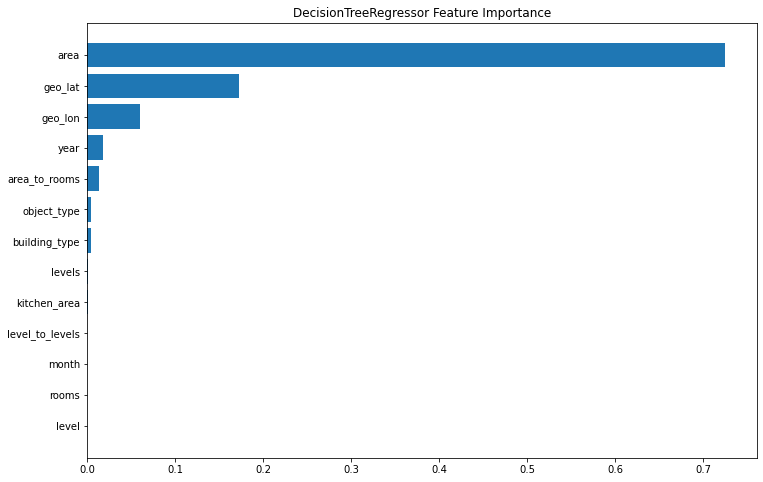

In [103]:
# Now lets see the feature importance for our DecisionTreeRegressor model

import matplotlib.pyplot as plt

# Display feature importance.
importance = pd.DataFrame({
    'features': X.columns,
    'importance': model_2.feature_importances_
})
importance.sort_values(by='importance', inplace=True)

plt.barh(importance['features'], importance['importance'])
plt.title('DecisionTreeRegressor Feature Importance')
plt.show()

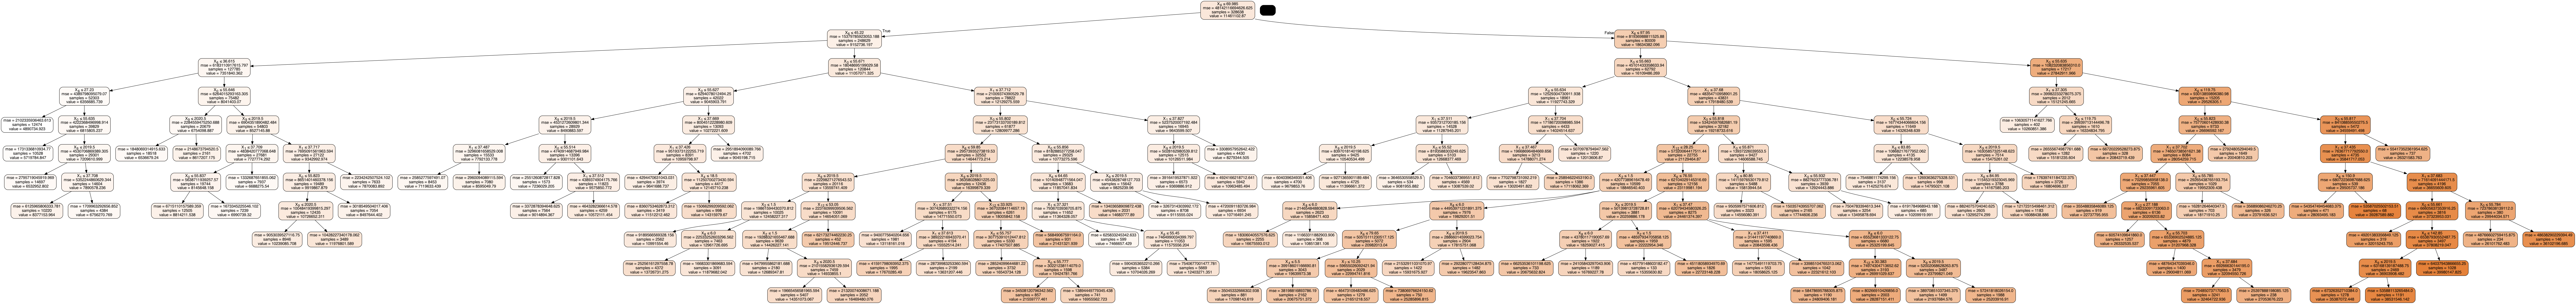

In [104]:
# let's visualize our decision tree with 

from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(model_2, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())


In [40]:
# Now let's try more complex ensemble models Random Forest Regressor and XGBRegressor

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='mean')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)])

# Define model
model_3 = XGBRegressor(n_estimators=50, random_state=SEED)
model_4 = RandomForestRegressor(n_estimators=50, random_state=SEED)



# Bundle preprocessing and modeling code in a pipeline
model_pip = Pipeline(steps=[
                            ('preprocessor', preprocessor),
                            ('scaler', MinMaxScaler()),
                            ('model', model_4)
                            ])

# Preprocessing of training data, fit model 
model_pip.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = model_pip.predict(X_test)

print('MAE:', mean_absolute_error(y_test, preds))
print('Model score:', model_pip.score(X_test, y_test))

MAE: 937390.7823445476
Model score: 0.9154269940949629


In [115]:
# now let's see CV for our second model XGBRegressor

from sklearn.model_selection import cross_val_score
result_final = cross_val_score(model_pip, X, y, cv=5)

print('XGBRegressor() model score: ', np.mean(result_final))
print('With STD: ', np.std(result_final))

XGBRegressor() model score:  0.8442751186870743
With STD:  0.02966086589643779


In [19]:
# now let's see CV for our second model RandomForestRegressor

from sklearn.model_selection import cross_val_score
result_final = cross_val_score(model_pip, X, y, cv=5)

print('RandomForestRegressor() model score: ', np.mean(result_final))
print('With STD: ', np.std(result_final))

RandomForestRegressor() model score:  0.8551101914920253
With STD:  0.026905149021437154


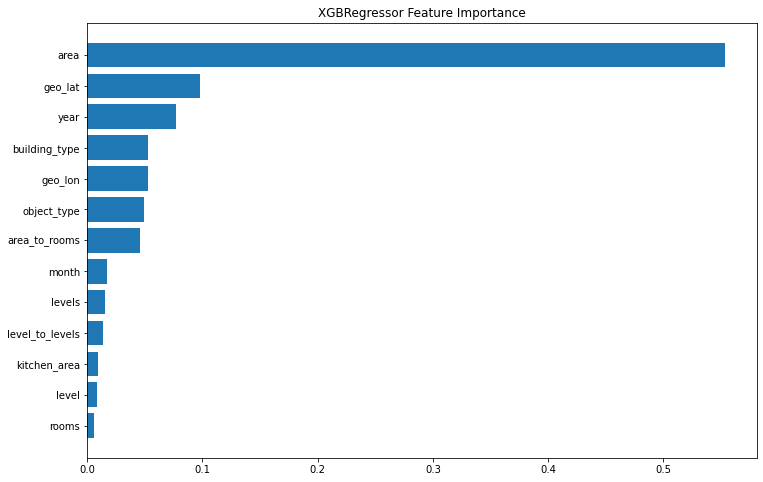

In [37]:
# Now lets see the feature importance according to our underlying model_3

import matplotlib.pyplot as plt

# Display feature importance.
importance = pd.DataFrame({
    'features': X.columns,
    'importance': model_3.feature_importances_
})
importance.sort_values(by='importance', inplace=True)

plt.figure(figsize=(12, 8))
plt.barh(importance['features'], importance['importance'])
plt.title('XGBRegressor Feature Importance')
plt.show()

In [38]:
# Safe the model

import joblib

filename = 'model_pip.sav'
joblib.dump(model_pip, filename)

['model_pip.sav']

In [39]:
# load the model from disk

loaded_model = joblib.load(filename)
loaded_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', SimpleImputer(),
                                                  ['geo_lat', 'geo_lon',
                                                   'building_type', 'level',
                                                   'levels', 'rooms', 'area',
                                                   'kitchen_area',
                                                   'object_type', 'year',
                                                   'month', 'level_to_levels',
                                                   'area_to_rooms']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                      

# Conclusions

As we can see, 4 models performance with default parameters:
1. LinearRegression model - 61% accuracy
2. DecisionTreeRegressor model - 73% accuracy 
3. XGBRegressor model - 84% accuracy
4. RandomForestRegressor - 85% accuracy

RandomForestRegressor model shows higher accuracy but harder to interpret and is the slowest model.
There were no signs of underfitting or overfitting throughout the process.
It is possible to acheive higher accuracy by adding additional features and tuning the hyperparameters.

Obviously total_area and geographic coordinates (district) are the most important features.
Additional data is highly required for weightened aproach to price prediction.